In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # Import AdamW from torch.optim instead
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import train_test_split
import nltk
from nltk.translate.bleu_score import sentence_bleu
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

2025-04-16 12:15:19.186563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744805719.493139      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744805719.571014      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Load and explore the dataset
df = pd.read_csv('/kaggle/input/football/final_commentary_dataset.csv')

# Display basic info
print(f"Dataset size: {len(df)}")
print("\nFirst few rows:")
df.head()

Dataset size: 1272

First few rows:


,Commentary,MatchReport
0,First Half begins. Foul by Dominic Calvert-Lew...,The first half saw a lot of back-and-forth pla...
1,"Corner, Arsenal. Conceded by Jarrad Branthwait...",Arsenal dominated possession with numerous att...
2,Fourth official has announced 1 minutes of add...,The match remains goalless. Arsenal had severa...
3,"Offside, Arsenal. Bukayo Saka is caught offsid...",The first half concluded scoreless. Arsenal ha...
4,"First Half begins. Offside, Liverpool. Cody Ga...",The first half saw Liverpool's Cody Gakpo scor...


Commentary length statistics:
count    1272.000000
mean      279.221698
std        86.029076
min        62.000000
25%       215.000000
50%       274.500000
75%       336.000000
max       500.000000
Name: Commentary_Length, dtype: float64

MatchReport length statistics:
count    1272.000000
mean       48.704403
std         7.395474
min        25.000000
25%        44.000000
50%        49.000000
75%        53.000000
max        73.000000
Name: MatchReport_Length, dtype: float64


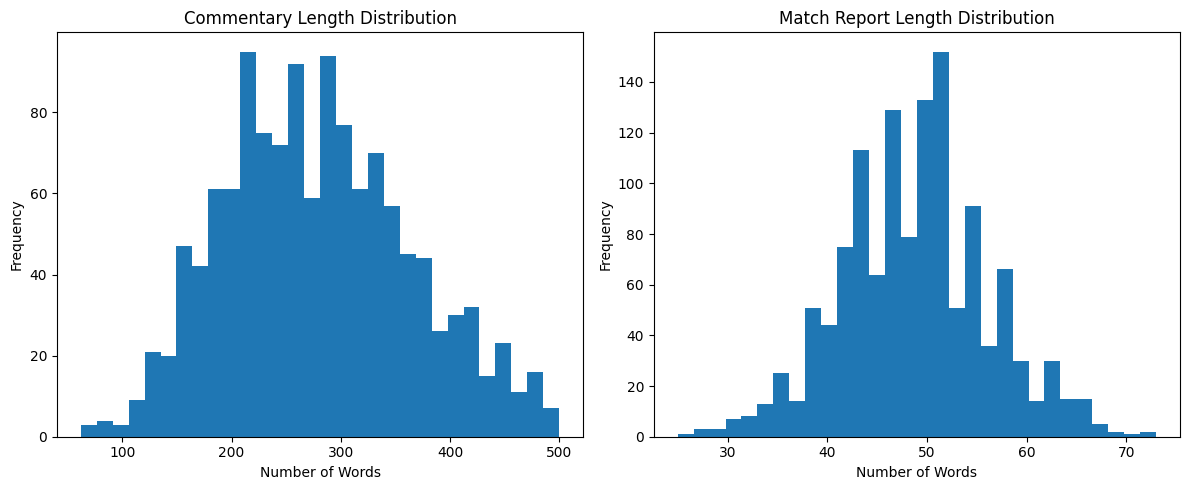

In [6]:
# Let's see length distributions
df['Commentary_Length'] = df['Commentary'].apply(lambda x: len(x.split()))
df['MatchReport_Length'] = df['MatchReport'].apply(lambda x: len(x.split()))

print("Commentary length statistics:")
print(df['Commentary_Length'].describe())
print("\nMatchReport length statistics:")
print(df['MatchReport_Length'].describe())

# Create histograms
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['Commentary_Length'], bins=30)
plt.title('Commentary Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['MatchReport_Length'], bins=30)
plt.title('Match Report Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [7]:
# Create train/validation/test splits
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 972
Validation set size: 172
Test set size: 128


In [8]:
# Create a PyTorch Dataset
class MatchDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        commentary = str(self.data.iloc[index]['Commentary'])
        match_report = str(self.data.iloc[index]['MatchReport'])
        
        # T5 expects a task prefix for different tasks
        # For text generation, we can use "summarize: " or create our own
        commentary_text = "generate match report: " + commentary
        
        # Tokenize inputs and outputs
        inputs = self.tokenizer.encode_plus(
            commentary_text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        targets = self.tokenizer.encode_plus(
            match_report,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': targets['input_ids'].squeeze()
        }

In [9]:
# Load tokenizer and model
model_name = "t5-small"  # ~60M parameters
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.to(device)

# Create datasets
train_dataset = MatchDataset(train_df, tokenizer)
val_dataset = MatchDataset(val_df, tokenizer)
test_dataset = MatchDataset(test_df, tokenizer)

# Create dataloaders
batch_size = 8  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [10]:
# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    for batch in progress_bar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Replace padding token id's with -100 so they are ignored in the loss
        labels[labels == tokenizer.pad_token_id] = -100
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'loss': loss.item()})
    
    return total_loss / len(dataloader)

In [11]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Replace padding token id's with -100 so they are ignored in the loss
            labels[labels == tokenizer.pad_token_id] = -100
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_loss += outputs.loss.item()
    
    return total_loss / len(dataloader)

In [12]:
# Generate predictions
def generate_match_report(model, tokenizer, commentary, device, max_length=512):
    model.eval()
    
    commentary_text = "generate match report: " + commentary
    inputs = tokenizer.encode_plus(
        commentary_text,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    ).to(device)
    
    output_ids = model.generate(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_length=max_length,
        num_beams=4,
        early_stopping=True
    )
    
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [13]:
# Set improved training parameters
epochs = 10  # Increase from 5 to 10 epochs
learning_rate = 2e-5  # Slightly lower learning rate for more stable training
warmup_steps = 200  # More warmup steps (was 100)
weight_decay = 0.01  # Add weight decay to reduce overfitting

# Gradient accumulation to effectively increase batch size
gradient_accumulation_steps = 4  # Accumulate gradients for 4 batches before updating

# Number of training steps
total_steps = (len(train_loader) // gradient_accumulation_steps) * epochs

# Prepare optimizer with weight decay
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    eps=1e-8  # More stable epsilon value
)

# Use cosine scheduler instead of linear for better convergence
from transformers import get_cosine_schedule_with_warmup
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Early stopping parameters
early_stopping_patience = 3
no_improve_epochs = 0

# Training loop with gradient accumulation and early stopping
best_val_loss = float('inf')
best_model_path = 'best_match_report_model.pt'
train_losses = []
val_losses = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    # Train with gradient accumulation
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc="Training")
    
    for i, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Replace padding token id's with -100 so they are ignored in the loss
        labels[labels == tokenizer.pad_token_id] = -100
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss / gradient_accumulation_steps  # Normalize loss
        total_loss += loss.item() * gradient_accumulation_steps  # Un-normalize for reporting
        
        loss.backward()
        
        # Update weights after accumulating gradients
        if (i + 1) % gradient_accumulation_steps == 0 or i == len(train_loader) - 1:
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        progress_bar.set_postfix({'loss': loss.item() * gradient_accumulation_steps})
    
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")
    
    # Evaluate
    val_loss = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model with validation loss: {val_loss:.4f}")
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1
        print(f"No improvement for {no_improve_epochs} epochs")
    
    # Early stopping
    if no_improve_epochs >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break
    
    print("-" * 50)

Epoch 1/10


Training:   0%|          | 0/122 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Train Loss: 3.5088


Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Loss: 3.2846
Saved new best model with validation loss: 3.2846
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/122 [00:00<?, ?it/s]

Train Loss: 3.3667


Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Loss: 3.0295
Saved new best model with validation loss: 3.0295
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/122 [00:00<?, ?it/s]

Train Loss: 3.1327


Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Loss: 2.7323
Saved new best model with validation loss: 2.7323
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/122 [00:00<?, ?it/s]

Train Loss: 2.8741


Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Loss: 2.5017
Saved new best model with validation loss: 2.5017
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/122 [00:00<?, ?it/s]

Train Loss: 2.6669


Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Loss: 2.3219
Saved new best model with validation loss: 2.3219
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/122 [00:00<?, ?it/s]

Train Loss: 2.5128


Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Loss: 2.1970
Saved new best model with validation loss: 2.1970
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/122 [00:00<?, ?it/s]

Train Loss: 2.4058


Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Loss: 2.1092
Saved new best model with validation loss: 2.1092
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/122 [00:00<?, ?it/s]

Train Loss: 2.3181


Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Loss: 2.0545
Saved new best model with validation loss: 2.0545
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/122 [00:00<?, ?it/s]

Train Loss: 2.2812


Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Loss: 2.0351
Saved new best model with validation loss: 2.0351
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/122 [00:00<?, ?it/s]

Train Loss: 2.2705


Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Loss: 2.0337
Saved new best model with validation loss: 2.0337
--------------------------------------------------


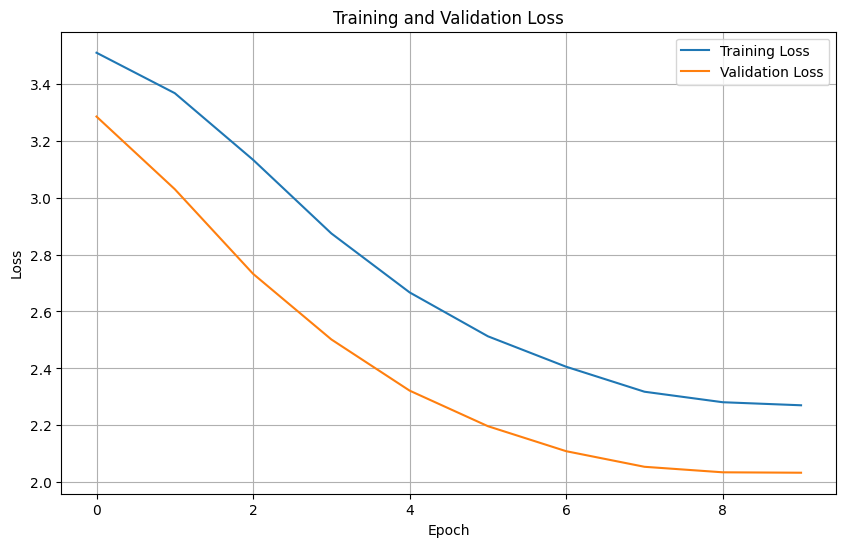

In [14]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Load the best model for evaluation
model.load_state_dict(torch.load(best_model_path))

# Evaluate on test set
test_loss = evaluate(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}")

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 2.0285


In [16]:
# Generate and evaluate a few examples
nltk.download('punkt')

def calculate_bleu(reference, candidate):
    reference_tokens = [reference.split()]
    candidate_tokens = candidate.split()
    return sentence_bleu(reference_tokens, candidate_tokens)

# Get some examples from test set
sample_indices = np.random.choice(len(test_df), 5, replace=False)
samples = test_df.iloc[sample_indices]

for i, row in samples.iterrows():
    commentary = row['Commentary']
    actual_report = row['MatchReport']
    
    print(f"Example {i}:")
    print(f"Commentary (truncated): {commentary[:200]}...")
    
    # Generate prediction
    generated_report = generate_match_report(model, tokenizer, commentary, device)
    print(f"Generated Report: {generated_report}")
    print(f"Actual Report: {actual_report}")
    
    # Calculate BLEU score
    bleu = calculate_bleu(actual_report, generated_report)
    print(f"BLEU Score: {bleu:.4f}")
    print("-" * 80)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Example 78:
Commentary (truncated): Jurriën Timber (Arsenal) wins a free kick in the defensive half. Foul by Omari Hutchinson (Ipswich Town). Substitution Substitution Attempt saved. Martin Ødegaard (Arsenal) left footed shot from the r...
Generated Report: Arsenal's Martin degaard had a shot saved and a header was saved. The match saw a delay in the match due to an injury to Martin degaard. The second half saw a delay in the match due to an injury to Jacob Greaves.
Actual Report: Arsenal had a dominant half, creating multiple chances but finding the Ipswich Town goalkeeper in top form. Ødegaard, Havertz and Merino all saw their shots saved. While Arsenal held onto their 1-0 lead at halftime, multiple substitutions and late injury stoppages led to extended added time.
BLEU Score: 0.0000
--------------------------------------------------------------------------------
Example 1214:
Commentary (truncated): Lamine Yamal (Barcelona) wins a free kick on the right wing. Foul by Carlos Martín 

Calculating BLEU scores:   0%|          | 0/128 [00:00<?, ?it/s]

Average BLEU Score: 0.0245


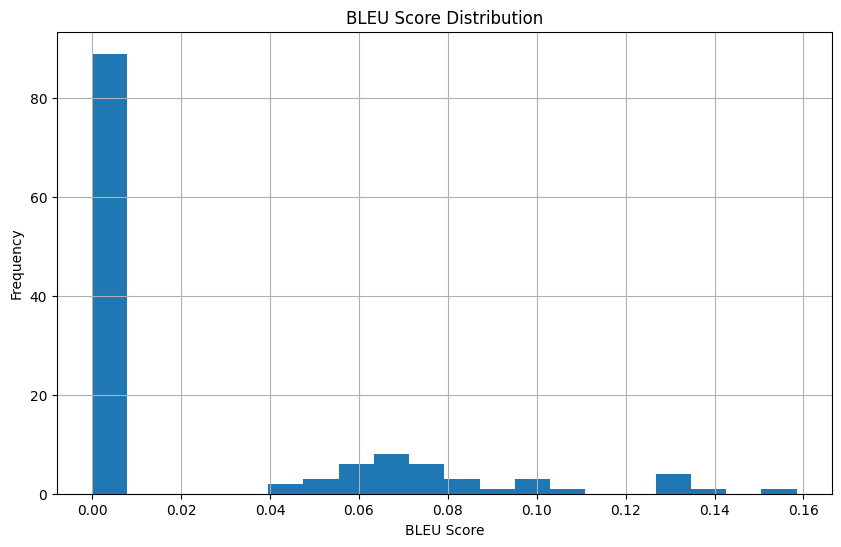

In [17]:
# Calculate BLEU for entire test set
total_bleu = 0
all_bleu_scores = []

for i, row in tqdm(test_df.iterrows(), desc="Calculating BLEU scores", total=len(test_df)):
    commentary = row['Commentary']
    actual_report = row['MatchReport']
    
    generated_report = generate_match_report(model, tokenizer, commentary, device)
    bleu = calculate_bleu(actual_report, generated_report)
    
    total_bleu += bleu
    all_bleu_scores.append(bleu)

average_bleu = total_bleu / len(test_df)
print(f"Average BLEU Score: {average_bleu:.4f}")

# Plot BLEU score distribution
plt.figure(figsize=(10, 6))
plt.hist(all_bleu_scores, bins=20)
plt.title('BLEU Score Distribution')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [29]:
# Save just the model weights and tokenizer vocabulary
torch.save(model.state_dict(), 'match_report_model12.pt')
tokenizer_info = {
    'vocab': tokenizer.get_vocab(),
    'special_tokens': tokenizer.special_tokens_map
}
torch.save(tokenizer_info, 'match_report_tokenizer.pt')
print("Model and tokenizer saved as lightweight files")

Model and tokenizer saved as lightweight files


In [25]:
# First, mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the target directory in Google Drive where you want to save your files
# Create this directory manually in your Drive first
drive_path = '/content/drive/'  # Change this to your preferred directory

# Create the directory if it doesn't exist
import os
if not os.path.exists(drive_path):
    os.makedirs(drive_path)
    print(f"Created directory: {drive_path}")

# Copy your model files to Google Drive
import shutil

# For individual files
source_files = [
    'match_report_model.pt',
    'match_report_tokenizer.pt'
    # Add other specific files you want to copy
]

for file in source_files:
    if os.path.exists(file):
        shutil.copy(file, os.path.join(drive_path, file))
        print(f"Copied {file} to Drive")
    else:
        print(f"Warning: {file} not found")


NotImplementedError: Mounting drive is unsupported in this environment. Use PyDrive instead. See examples at https://colab.research.google.com/notebooks/io.ipynb#scrollTo=7taylj9wpsA2.

In [ ]:
import shutil

shutil.make_archive('zipped_file_name', 'zip', '/kaggle/working/')


RuntimeError: File size too large, try using force_zip64